# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import time
import datetime

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [4]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [15]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.4899999890476465


In [16]:
#DeepDeterminsticPolicyGradient DDPG
from nn_model import Actor , Critic
from agent import AiAgent

In [17]:
#create the instance of AiAgent
reacherAI = AiAgent(state_size,action_size,random_seed=9)
print(reacherAI.actor_local)
print(reacherAI.critic_local)

Actor(
  (fc1): Linear(in_features=33, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=24, bias=True)
  (fc2): Linear(in_features=28, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=1, bias=True)
)


In [18]:
# Deep Determinsitic Policy Gradient Algorithm
# Policy Based -Actor Critic Method

def Ddpg(n_episodes=5000, max_t=300, print_every=100):
    
    scores_ddpg = []                           #Final Scores to Plot
    rewards_plot = []
    episode_reward=np.zeros(num_agents) 
    scores = np.zeros(num_agents)              #Reward for the Episodes reset
    scores_window = deque(maxlen=print_every)  #Window for every 100 episodes
    
    for i_episode in range(1, n_episodes+1):
        #reset the unity Env_info for each new episode
        env_info = env.reset(train_mode=True)[brain_name]
        
        #set initial state
        state = env_info.vector_observations  #[0] Current state 
        #Reset
        reacherAI.reset()
        rewards = 0
        counter_i=0
        episode_reward=np.zeros(num_agents) 
        #For each Episode,  take max steps and record the state and reward information until Episode complete       
        while True: # t in range(max_t):
            #Select action based on  policy based
            action = reacherAI.act(state)
            #action = np.clip(action, -1, 1) #np.clip (0 or 1 )taken care in Agent.Act
            
           
            env_info = env.step(action)[brain_name]   #Perform 'action'
            next_state = env_info.vector_observations #Next env state info 
            
            rewards = env_info.rewards                 #reward +0.1 for every timestep
            done   = env_info.local_done              #Episode complete
            scores += rewards                          #Accumulate Rewards
            state = next_state                        #mark new state as current state
            episode_reward+=rewards
            
            
                
            #Store the experience for Replay to make decision - better policy
            if np.any(done):
                reacherAI.step (state, action,scores,next_state,done)
                rewards_plot.append(episode_reward)              #Rewards from each episode
                scores_window.append(episode_reward)                  #Print the windows score
                break             
            #if np.any(done) :                         #When the episodes complete
            #   break
            scores_ddpg.append(scores)                 #Actual Reward from this Episode to be returned
            #scores_window.append(episode_reward)                  #Print the windows score 
        
       
        print('Total score (averaged over agents) this episode {}\t: {}'.format(i_episode,np.mean(scores)))  
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage  Score: {:.4f}\t AcScore {:.4f}'.format(i_episode, np.mean(scores_window),np.mean(scores)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic.pth')
        if np.mean(scores)>=30.0 and i_episode >100 :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor30_23jul.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic30_23jul.pth')
            break
              
                   
    return rewards_plot
#Latest23

2020-07-23 08:44:14.072734
Total score (averaged over agents) this episode 1	: 0.1099999975413084
Total score (averaged over agents) this episode 2	: 0.1599999964237213
Total score (averaged over agents) this episode 3	: 0.1599999964237213
Total score (averaged over agents) this episode 4	: 0.1599999964237213
Total score (averaged over agents) this episode 5	: 0.1599999964237213
Total score (averaged over agents) this episode 6	: 0.1599999964237213
Total score (averaged over agents) this episode 7	: 0.1599999964237213
Total score (averaged over agents) this episode 8	: 0.1599999964237213
Total score (averaged over agents) this episode 9	: 0.1599999964237213
Total score (averaged over agents) this episode 10	: 0.1599999964237213
Total score (averaged over agents) this episode 11	: 0.25999999418854713
Total score (averaged over agents) this episode 12	: 0.25999999418854713
Total score (averaged over agents) this episode 13	: 0.25999999418854713
Total score (averaged over agents) this epi

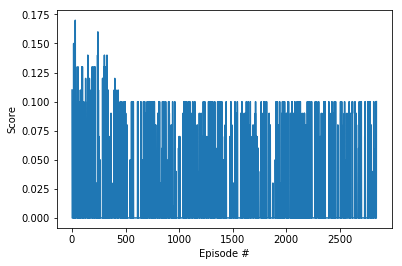

In [19]:
# Ver 13 
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 300       #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0        # L2 weight decay

#Noise mu=0., theta=0.17, sigma=0.24
#Random seed = 9
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=3000)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#Episode 100	Average  Score: 0.0178	 AcScore 1.7800
#Episode 200	Average  Score: 0.0120	 AcScore 2.9800
#Episode 300	Average  Score: 0.0131	 AcScore 4.2900
#Episode 400	Average  Score: 0.0150	 AcScore 5.7900
#Episode 500	Average  Score: 0.0180	 AcScore 7.5900
#Episode 600	Average  Score: 0.0107	 AcScore 8.6600
#Episode 700	Average  Score: 0.0077	 AcScore 9.4300
#Episode 800	Average  Score: 0.0129	 AcScore 10.7200
#Episode 900	Average  Score: 0.0111	 AcScore 11.8300
#Episode 1000	Average  Score: 0.0076	 AcScore 12.5900
#Episode 1100	Average  Score: 0.0110	 AcScore 13.6900
#Episode 1200	Average  Score: 0.0084	 AcScore 14.5300
#Episode 1300	Average  Score: 0.0105	 AcScore 15.5800
#Episode 1400	Average  Score: 0.0143	 AcScore 17.0100
#Episode 1500	Average  Score: 0.0055	 AcScore 17.5600
#Episode 1600	Average  Score: 0.0094	 AcScore 18.5000
#Episode 1700	Average  Score: 0.0105	 AcScore 19.5500
#Episode 1800	Average  Score: 0.0084	 AcScore 20.3900
#Episode 1900	Average  Score: 0.0046	 AcScore 20.8500
#Episode 2000	Average  Score: 0.0084	 AcScore 21.6900
#Episode 2100	Average  Score: 0.0121	 AcScore 22.9000
#Episode 2200	Average  Score: 0.0144	 AcScore 24.3400
#Episode 2300	Average  Score: 0.0079	 AcScore 25.1300
#Episode 2400	Average  Score: 0.0106	 AcScore 26.1900
#Episode 2500	Average  Score: 0.0056	 AcScore 26.7500
#Episode 2600	Average  Score: 0.0113	 AcScore 27.8800
#Episode 2700	Average  Score: 0.0086	 AcScore 28.7400
#Episode 2800	Average  Score: 0.0086	 AcScore 29.6000
#Environment solved in 2842 episodes!	Average Score: 30.1000

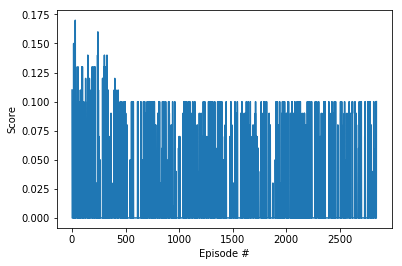

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [23]:
scores_bkup23rdjul= scores

In [ ]:
#Learnings:
    Sometimes it make us focus in depth understanding and tuning of algos but may miss simple front end part. 
    1. Most common mistake did was not reset the scores 'counter array' so only recent scores scored
    2. Before running long hr training process (like here avg 8 to 10 hrs it took for me to achieve 30+ score' ) please dry run your logic with simple 1 to 10 episodes
    3. After all my 2 extended nights, but got an error on last Printing the time taken so made me restart from point 0 :|
    4. Cud see the OS also matters ...same code , i tried running in Udacity provided workspace (linux) and Windows in my local machines. Same logic but coud see difference in scores average in each episodes. So i tested intial 200 runs to see which seed gets me relatively high score chosen to tune the parameteres
    5. Buffer size can be large but keep the Mini batch - random sampling for correaltions- less than 256
    6. Agent storing history to Replay Memory - its crirtical .. I was oversighted initially by just calling the aiReacher.Step but got right scores by having the condition once the Episode complete with 'done'
    7. Couldn't find much difference using of GPU vs CPU . So completely ran in 'CPU' and saved 'GPU' hrs for next project
    8. 

In [26]:
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30_23jul.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30_23jul.pth'))

env_info = env.reset(train_mode=False)[brain_name]
scores_t = np.zeros(num_agents)       
#set initial state
state = env_info.vector_observations

for t in range(500):
    action = reacherAI.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done   = env_info.local_done
    scores_t += reward                       
    state = next_state
           
    if np.any(done):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores_t)))  

Total score (averaged over agents) this episode: 0.0


# HOPE

2020-07-23 08:35:11.193247
Total score (averaged over agents) this episode 1	: 0.0
Total score (averaged over agents) this episode 2	: 0.0
Total score (averaged over agents) this episode 3	: 0.0
Total score (averaged over agents) this episode 4	: 0.0
Total score (averaged over agents) this episode 5	: 0.0
Total score (averaged over agents) this episode 6	: 0.0
Total score (averaged over agents) this episode 7	: 0.0
Total score (averaged over agents) this episode 8	: 0.0
Total score (averaged over agents) this episode 9	: 0.0
Total score (averaged over agents) this episode 10	: 0.0
Episode 10	Average  Score: 0.0000	 AcScore 0.0000
Total score (averaged over agents) this episode 11	: 0.0
Total score (averaged over agents) this episode 12	: 0.0
Total score (averaged over agents) this episode 13	: 0.0
Total score (averaged over agents) this episode 14	: 0.0
Total score (averaged over agents) this episode 15	: 0.0
Total score (averaged over agents) this episode 16	: 0.0
Total score (average

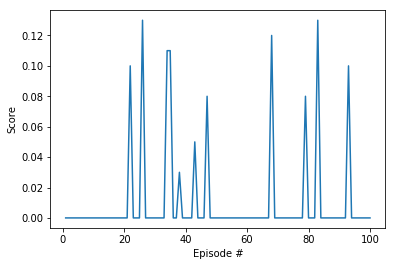

In [14]:
#Episode score reset to zero for new one and add value once done print each episode 
#SCORES - Episode print number,Avg score,and accumulate score updated in np.any(done)
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=100)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-23 07:27:08.680229
Total score (averaged over agents) this episode 1	: 0.0
Total score (averaged over agents) this episode 2	: 0.09999999776482582
Total score (averaged over agents) this episode 3	: 0.09999999776482582
Total score (averaged over agents) this episode 4	: 0.09999999776482582
Total score (averaged over agents) this episode 5	: 0.09999999776482582
Total score (averaged over agents) this episode 6	: 0.09999999776482582
Total score (averaged over agents) this episode 7	: 0.09999999776482582
Total score (averaged over agents) this episode 8	: 0.09999999776482582
Total score (averaged over agents) this episode 9	: 0.09999999776482582
Total score (averaged over agents) this episode 10	: 0.09999999776482582
Episode 10	Average  Score: 0.0000	 AcScore 0.1000
Total score (averaged over agents) this episode 11	: 0.09999999776482582
Total score (averaged over agents) this episode 12	: 0.09999999776482582
Total score (averaged over agents) this episode 13	: 0.09999999776482582

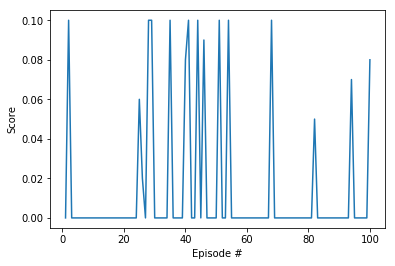

In [76]:
#Episode score reset to zero for new one and add value once done print each episode SCORES - Episode print number,Avg score,and accumulate score
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=100)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-23 07:20:26.016825
Total score (averaged over agents) this episode 1	: 0.0
Total score (averaged over agents) this episode 2	: 0.0
Total score (averaged over agents) this episode 3	: 0.0
Total score (averaged over agents) this episode 4	: 0.0
Total score (averaged over agents) this episode 5	: 0.0
Total score (averaged over agents) this episode 6	: 0.0
Total score (averaged over agents) this episode 7	: 0.0
Total score (averaged over agents) this episode 8	: 0.0
Total score (averaged over agents) this episode 9	: 0.09999999776482582
Total score (averaged over agents) this episode 10	: 0.09999999776482582
Episode 10	Average  Score: 0.0000
Total score (averaged over agents) this episode 11	: 0.09999999776482582
Total score (averaged over agents) this episode 12	: 0.09999999776482582
Total score (averaged over agents) this episode 13	: 0.09999999776482582
Total score (averaged over agents) this episode 14	: 0.09999999776482582
Total score (averaged over agents) this episode 15	: 0

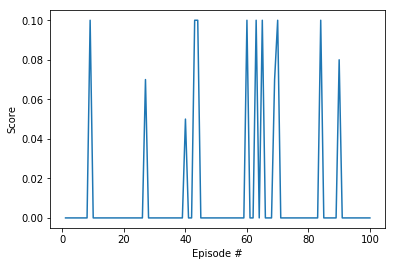

In [74]:
#Episode score reset to zero for new one and add value once done print each episode SCORES
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=100)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#break 1pm

2020-07-23 07:17:13.391925
Total score (averaged over agents) this episode 1	: 0.0
Total score (averaged over agents) this episode 2	: 0.0
Total score (averaged over agents) this episode 3	: 0.0
Total score (averaged over agents) this episode 4	: 0.0
Total score (averaged over agents) this episode 5	: 0.0
Total score (averaged over agents) this episode 6	: 0.0
Total score (averaged over agents) this episode 7	: 0.0
Total score (averaged over agents) this episode 8	: 0.0
Total score (averaged over agents) this episode 9	: 0.0
Total score (averaged over agents) this episode 10	: 0.0
Episode 10	Average  Score: 0.0000
Total score (averaged over agents) this episode 11	: 0.0
Total score (averaged over agents) this episode 12	: 0.0
Total score (averaged over agents) this episode 13	: 0.09999999776482582
Total score (averaged over agents) this episode 14	: 0.0
Total score (averaged over agents) this episode 15	: 0.09999999776482582
Total score (averaged over agents) this episode 16	: 0.0
Tota

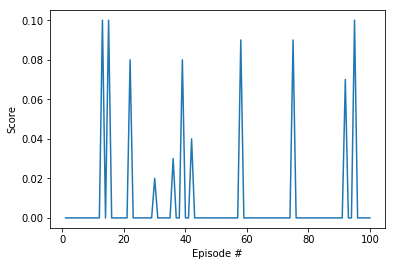

In [72]:
#Episode score reset to zero for new one and add value once done print each episode episode_rewars 
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=100)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-23 06:33:55.173582
Total score (averaged over agents) this episode 1	: 0.0
Total score (averaged over agents) this episode 2	: 0.0
Total score (averaged over agents) this episode 3	: 0.0
Total score (averaged over agents) this episode 4	: 0.0
Total score (averaged over agents) this episode 5	: 0.0
Total score (averaged over agents) this episode 6	: 0.0
Total score (averaged over agents) this episode 7	: 0.0
Total score (averaged over agents) this episode 8	: 0.0
Total score (averaged over agents) this episode 9	: 0.0
Total score (averaged over agents) this episode 10	: 0.0
Total score (averaged over agents) this episode 11	: 0.0
Total score (averaged over agents) this episode 12	: 0.0
Total score (averaged over agents) this episode 13	: 0.0
Total score (averaged over agents) this episode 14	: 0.0
Total score (averaged over agents) this episode 15	: 0.0
Total score (averaged over agents) this episode 16	: 0.0
Total score (averaged over agents) this episode 17	: 0.129999997094273

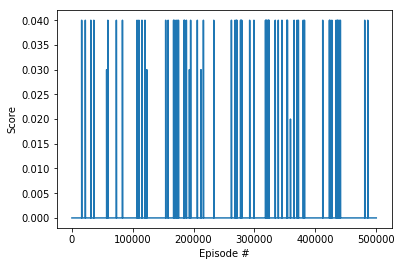

In [61]:
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=500)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-23 06:56:27.162713
Total score (averaged over agents) this episode 1	: 0.0
Total score (averaged over agents) this episode 2	: 0.0
Total score (averaged over agents) this episode 3	: 0.0
Total score (averaged over agents) this episode 4	: 0.0
Total score (averaged over agents) this episode 5	: 0.0
Total score (averaged over agents) this episode 6	: 0.0
Total score (averaged over agents) this episode 7	: 0.0
Total score (averaged over agents) this episode 8	: 0.09999999776482582
Total score (averaged over agents) this episode 9	: 0.09999999776482582
Total score (averaged over agents) this episode 10	: 0.09999999776482582
Total score (averaged over agents) this episode 11	: 0.09999999776482582
Total score (averaged over agents) this episode 12	: 0.09999999776482582
Total score (averaged over agents) this episode 13	: 0.09999999776482582
Total score (averaged over agents) this episode 14	: 0.09999999776482582
Total score (averaged over agents) this episode 15	: 0.09999999776482582

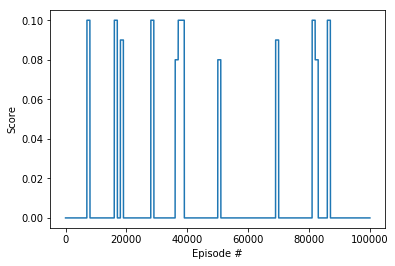

In [65]:
# Ver Q1
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 300       #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0        # L2 weight decay

#Noise mu=0., theta=0.17, sigma=0.24
#Random seed = 9
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=100)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [57]:
print(scores)

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]

In [16]:
# Deep Determinsitic Policy Gradient Algorithm

def Ddpg(n_episodes=5000, max_t=300, print_every=100):
    
    scores_ddpg = []                           #Final Scores to Plot
    scores = np.zeros(num_agents)              #Reward for the Episodes reset
    scores_window = deque(maxlen=print_every)  #Window for every 100 episodes
    
    for i_episode in range(1, n_episodes+1):
        #reset the unity Env_info for each new episode
        env_info = env.reset(train_mode=True)[brain_name]
        
        #set initial state
        state = env_info.vector_observations  #[0] Current state 
        #Reset
        reacherAI.reset()
        rewards = 0
        
        
        #For each Episode,  take max steps and record the state and reward information until Episode complete       
        while True: # t in range(max_t):
            #Select action based on  policy based
            action = reacherAI.act(state)
            #action = np.clip(action, -1, 1) #np.clip (0 or 1 )taken care in Agent.Act
            
           
            env_info = env.step(action)[brain_name]   #Perform 'action'
            next_state = env_info.vector_observations #Next env state info 
            
            rewards = env_info.rewards                 #reward +0.1 for every timestep
            done   = env_info.local_done              #Episode complete
            scores += rewards                          #Accumulate Rewards
            state = next_state                        #mark new state as current state
            
            #Store the experience for Replay to make decision - better policy
            if np.any(done):
                reacherAI.step (state, action,scores,next_state,done)
                break             
            #if np.any(done) :                         #When the episodes complete
            #   break
            scores_ddpg.append(scores)                 #Actual Reward from this Episode to be returned
            scores_window.append(scores)                  #Print the windows score 
        
       
        print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))  
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage  Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic.pth')
        if np.mean(scores)>=30.0 and i_episode >100 :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor30.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic30.pth')
            break
              
                   
    return scores_ddpg


2020-07-22 15:47:12.870975
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.3499999921768904
Total score (averaged over agents) this episode: 0.3499999921768904
Total score (averaged over agents) this episode: 0.3499999921768904
Total score (averaged over 

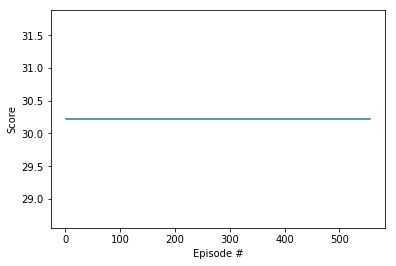

In [11]:
# Ver Q1
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 300       #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0        # L2 weight decay

#Noise mu=0., theta=0.17, sigma=0.24
#Random seed = 9
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=3000)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# Ver Q1
#BUFFER_SIZE = 500000      # replay buffer size
#BATCH_SIZE = 300          # minibatch size
#GAMMA = 0.997             # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3          # learning rate of the critic
#WEIGHT_DECAY = 0          # L2 weight decay
#Random seed = 9
#theta=0.17, sigma=0.24    #Noise - Exploration


#Episode 100	Average  Score: 4.4800
#Episode 200	Average  Score: 8.5400
#Episode 300	Average  Score: 14.6500
#Episode 400	Average  Score: 18.2800
#Episode 500	Average  Score: 24.9900
#Environment solved in 556 episodes!	Average Score: 30.2200
3:39:29.081889

In [ ]:
#Ver 10.3 22nd Jul

#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.00013         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0  
#seed 3
#Noise mu=0., theta=0.17, sigma=0.24
#Random seed = 3
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=3000)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-22 12:24:48.812776
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.1099999975413084
Total score 

In [ ]:
#Quick Reference on the Training scores by Score_window
#Episode 100	Average  Score: 0.7000 
#Episode 200	Average  Score: 3.0400
#Episode 300	Average  Score: 4.9200
#Episode 400	Average  Score: 7.0400
#Episode 500	Average  Score: 9.7200
#Episode 600	Average  Score: 11.6900

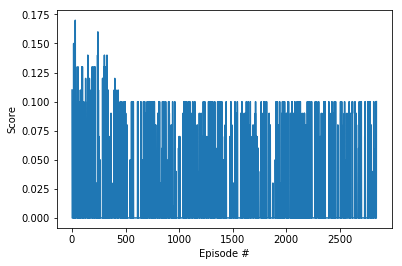

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
#plt.plot(np.arange(len(scores)), 30*np.ones(len(scores)))# print avg score 30
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Watch the Trained Agent - Loading the weights and Test


In [14]:
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30.pth'))

env_info = env.reset(train_mode=False)[brain_name]
scores_t = np.zeros(num_agents)       
#set initial state
state = env_info.vector_observations

for t in range(1000):
    action = reacherAI.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done   = env_info.local_done
    scores_t += reward                       
    state = next_state
           
    if np.any(done):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores_t)))  

Total score (averaged over agents) this episode: 1.3699999693781137


In [ ]:
env.close()

# Learning 

#Learnings:
    Sometimes it make us focus in depth understanding and tuning of algos but may miss simple front end part. 
    1. Most common mistake did was not reset the scores 'counter array' so only recent scores scored
    2. Before running long hr training process (like here avg 8 to 10 hrs it took for me to achieve 30+ score' ) please dry run your logic with simple 1 to 10 episodes
    3. After all my 2 extended nights, but got an error on last Printing the time taken so made me restart from point 0 :|
    4. Cud see the OS also matters ...same code , i tried running in Udacity provided workspace (linux) and Windows in my local machines. Same logic but coud see difference in scores average in each episodes. So i tested intial 200 runs to see which seed gets me relatively high score chosen to tune the parameteres
    5. Buffer size can be large but keep the Mini batch - random sampling for correaltions- less than 256
    6. Agent storing history to Replay Memory - its crirtical .. I was oversighted initially by just calling the aiReacher.Step but got right scores by having the condition once the Episode complete with 'done'
    7. Couldn't find much difference using of GPU vs CPU . So completely ran in 'CPU' and saved 'GPU' hrs for next project
    8. 

# History - Trails and more Errors 

In [74]:
# Deep Determinsitic Policy Gradient Algorithm

def Ddpg(n_episodes=5000, max_t=300, print_every=100):
    
    scores_ddpg = []                           #Final Scores to Plot
    scores = np.zeros(num_agents)              #Reward for the Episodes reset
    scores_window = deque(maxlen=print_every)  #Window for every 100 episodes
    episode_avg_score = []
    episode_avg_score.append(0)
    for i_episode in range(1, n_episodes+1):
        episode_scores = np.zeros(num_agents)
        #reset the unity Env_info for each new episode
        env_info = env.reset(train_mode=True)[brain_name]
        
        #set initial state
        state = env_info.vector_observations  #[0] Current state 
        #Reset
        reacherAI.reset()
        rewards = 0
        
        
        #For each Episode,  take max steps and record the state and reward information until Episode complete       
        while True: # t in range(max_t):
            #Select action based on  policy based
            action = reacherAI.act(state)
            #action = np.clip(action, -1, 1) #np.clip (0 or 1 )taken care in Agent.Act
            
           
            env_info = env.step(action)[brain_name]   #Perform 'action'
            next_state = env_info.vector_observations #Next env state info 
            
            rewards = env_info.rewards                 #reward +0.1 for every timestep
            done   = env_info.local_done              #Episode complete
            episode_scores +=rewards               #Actual Reward from this Episode to be returned
            state = next_state                        #mark new state as current state
            #Store the experience for Replay to make decision - better policy
            if np.any(done):
                reacherAI.step(state, action,scores,next_state,done)
                break             
        scores_ddpg.append(np.mean(episode_scores))   
        scores_window.append(np.mean(episode_scores))                  #Print the windows score
        episode_avg_score=np.mean(scores_window)
        print('Total score (averaged over agents) this episode: {}:\t{:.4f}\tAverage Score:\t{:.4f}'
              .format(i_episode,np.mean(episode_scores),episode_avg_score))  
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage  Score: {:.4f}'.format(i_episode, episode_avg_score))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic.pth')
        if episode_avg_score>30.0 :
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, episode_avg_score))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor30.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic30.pth')
            break
              
                   
    return scores_ddpg


In [75]:
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=3000)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(len(scores)), 30*np.ones(len(scores)))# print avg score 30
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-22 21:31:50.922570
Total score (averaged over agents) this episode: 1:	0.4200	Average Score:	0.4200
Total score (averaged over agents) this episode: 2:	0.0000	Average Score:	0.2100
Total score (averaged over agents) this episode: 3:	0.0000	Average Score:	0.1400
Total score (averaged over agents) this episode: 4:	0.1900	Average Score:	0.1525
Total score (averaged over agents) this episode: 5:	0.0000	Average Score:	0.1220
Total score (averaged over agents) this episode: 6:	0.5300	Average Score:	0.1900
Total score (averaged over agents) this episode: 7:	0.7100	Average Score:	0.2643
Total score (averaged over agents) this episode: 8:	0.0000	Average Score:	0.2312
Total score (averaged over agents) this episode: 9:	0.0000	Average Score:	0.2056
Total score (averaged over agents) this episode: 10:	0.0000	Average Score:	0.1850
Total score (averaged over agents) this episode: 11:	0.0000	Average Score:	0.1682
Total score (averaged over agents) this episode: 12:	0.2700	Average Score:	0.176

KeyboardInterrupt: 

2020-07-22 21:28:47.460388
Total score (averaged over agents) this episode: 1:	0.0000	Average Score:	0.0000
Total score (averaged over agents) this episode: 2:	0.0000	Average Score:	0.0000
Total score (averaged over agents) this episode: 3:	0.0000	Average Score:	0.0000
Total score (averaged over agents) this episode: 4:	0.0000	Average Score:	0.0000
Total score (averaged over agents) this episode: 5:	0.0000	Average Score:	0.0000
Total score (averaged over agents) this episode: 6:	0.0000	Average Score:	0.0000
Total score (averaged over agents) this episode: 7:	0.0000	Average Score:	0.0000
Total score (averaged over agents) this episode: 8:	0.1000	Average Score:	0.0125
Total score (averaged over agents) this episode: 9:	0.0000	Average Score:	0.0111
Total score (averaged over agents) this episode: 10:	0.5400	Average Score:	0.0640
Episode 10	Average  Score: 0.0640
0:00:18.107546


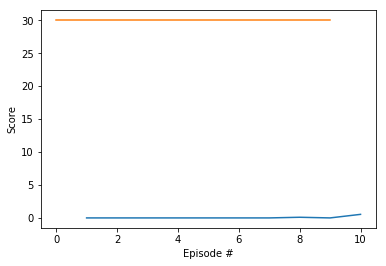

In [72]:
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=10)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(len(scores)), 30*np.ones(len(scores)))# print avg score 30
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

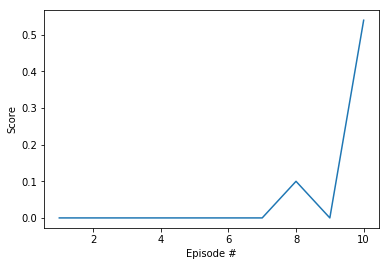

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
#plt.plot(np.arange(len(scores)), 30*np.ones(len(scores)))# print avg score 30
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-22 20:41:21.240386
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.4399999901652336
Total score (averaged over agents) this episode: 0.4399999901652336
Total score (averaged over agents) this episode: 0.4399999901652336
Total score (averaged over agents) this episode: 0.4999999888241291
Total score (averaged over agents) this episode: 0.8199999816715717
Total score (averaged over agents) this episode: 0.8199999816715717
Total score (averaged over agents) this episode: 0.9899999778717756
Total score (averaged over agents) this episode: 0.9899999778717756
Episode 10	Average  Score: 0.9900
0:00:18.150691


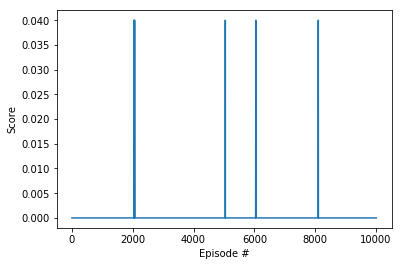

In [60]:
# Ver Q1
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 300       #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0        # L2 weight decay

#Noise mu=0., theta=0.17, sigma=0.24
#Random seed = 9
start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=10)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [55]:
print(scores)

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]

In [ ]:
#Quick Reference on the Training scores by Score_window
#Episode 100	Average  Score: 0.7000 
#Episode 200	Average  Score: 3.0400
#Episode 300	Average  Score: 4.9200
#Episode 400	Average  Score: 7.0400

In [ ]:
#Environment Close
env.close()

#Learnings:
    Sometimes it make us focus in depth understanding and tuning of algos but may miss simple front end part. 
    1. Most common mistake did was not reset the scores 'counter array' so only recent scores scored
    2. Before running long hr training process (like here avg 8 to 10 hrs it took for me to achieve 30+ score' ) please dry run your logic with simple 1 to 10 episodes
    3. After all my 2 extended nights, but got an error on last Printing the time taken so made me restart from point 0 :|
    4. Cud see the OS also matters ...same code , i tried running in Udacity provided workspace (linux) and Windows in my local machines. Same logic but coud see difference in scores average in each episodes. So i tested intial 200 runs to see which seed gets me relatively high score chosen to tune the parameteres
    5. Buffer size can be large but keep the Mini batch - random sampling for correaltions- less than 256
    6. Agent storing history to Replay Memory - its crirtical .. I was oversighted initially by just calling the aiReacher.Step but got right scores by having the condition once the Episode complete with 'done'
    7. Couldn't find much difference using of GPU vs CPU . So completely ran in 'CPU' and saved 'GPU' hrs for next project
    8. 

In [ ]:
#Ver 10.2 22nd Jul

#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.00013         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0  
#seed 3

start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=3000)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-22 09:36:48.590885
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.029999999329447746
Total score (averaged over agents) this episode: 0.09999999776482582
Total score (averaged over agents) this episode: 0.1699999962002039
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.19999999552965164
Total score (averaged over agents) this episode: 0.0
Total sc

In [ ]:
#Ver 10.1 22nd Jul

#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.00013         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0  
#seed 3

start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=3000)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-22 08:50:18.978874
Total score (averaged over agents) this episode: 0.05999999865889549
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 1.3299999702721834
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.07999999821186066
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged ove

Episode 100	Average  Score: 0.0358

2020-07-22 08:47:13.285569
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.019999999552965164
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Total score (averaged over agents) this episode: 0.0
Episode 10	Average  Score: 0.0020
0:01:53.163274


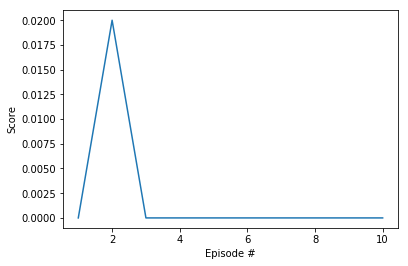

In [12]:
#Ver 10 22nd Jul

#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.00013         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0  
#seed 3

start = datetime.datetime.now()
print (start)
scores = Ddpg(n_episodes=10)
endtime = datetime.datetime.now() -start
print (endtime)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 25	Average Score: 0.0900 2020-07-22 06:19:38.862864


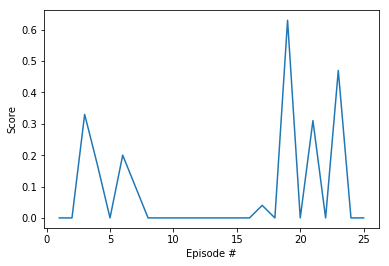

In [19]:
#Ver 7.7 20Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.00013         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0  
#seed 3

scores = Ddpg(n_episodes=25)
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 10	Average Score: 0.0400 2020-07-22 03:31:05.430872


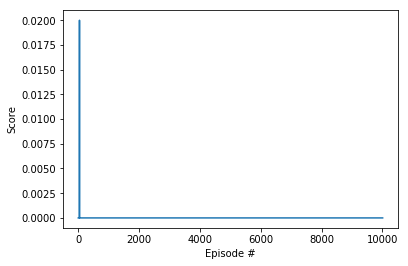

In [15]:
scores = Ddpg(n_episodes=10)
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-21 13:57:17.113675
Episode 100	Average Score: 0.7000 
Episode 200	Average Score: 3.0400 
Episode 300	Average Score: 4.9200 
Episode 400	Average Score: 7.0400 
Episode 500	Average Score: 9.7200 
Episode 600	Average Score: 11.6900 
Episode 700	Average Score: 14.2900 
Episode 800	Average Score: 17.8700 
Episode 900	Average Score: 22.0000 
Episode 1000	Average Score: 26.7700 
Episode 1100	Average Score: 28.8000 
Episode 1200	Average Score: 29.7400 
Episode 1243	Average Score: 30.1600 
Environment solved in 1243 episodes!	Average Score: 30.1600
2020-07-21 21:24:18.656731


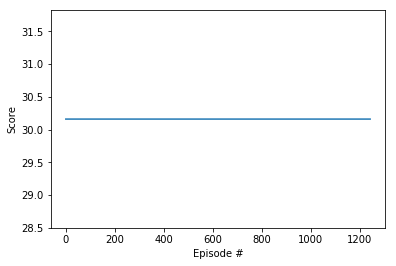

In [11]:
#Ver 7.7 20Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.00013         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0  
#seed 3

scores = Ddpg(n_episodes=5000)
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [16]:
env.close()

# Background work - 

In [14]:
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30.pth'))

env_info = env.reset(train_mode=False)[brain_name]
scores = np.zeros(num_agents)       
#set initial state
state = env_info.vector_observations

for t in range(1000):
    action = reacherAI.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done   = env_info.local_done
    scores += reward                       
    state = next_state
           
    if np.any(done):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))  

Total score (averaged over agents) this episode: 0.0


In [ ]:
#Ver 7.7 20Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 128        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg(n_episodes=5000)
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-21 13:31:12.877648
Episode 100	Average Score: 0.3600 
Episode 165	Average Score: 0.5100 

In [ ]:
#Ver 7.6 20Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 128        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg(n_episodes=5000)
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-21 06:43:24.765966
Episode 100	Average Score: 2.4500 
Episode 200	Average Score: 4.4300 
Episode 300	Average Score: 6.3400 
Episode 400	Average Score: 7.2400 
Episode 500	Average Score: 8.2200 
Episode 600	Average Score: 9.0900 
Episode 700	Average Score: 10.2400 
Episode 800	Average Score: 10.9700 
Episode 900	Average Score: 11.9300 
Episode 1000	Average Score: 12.6300 
Episode 1100	Average Score: 13.9600 
Episode 1200	Average Score: 15.0700 
Episode 1300	Average Score: 16.1900 
Episode 1361	Average Score: 16.6700 

In [13]:
#Ver 7.5 19Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 128        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg(n_episodes=3000)
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-21 00:21:28.166461
Episode 100	Average Score: 3.0200 
Episode 200	Average Score: 5.5300 
Episode 300	Average Score: 7.7300 
Episode 400	Average Score: 8.6700 
Episode 500	Average Score: 10.0400 
Episode 600	Average Score: 11.1100 
Episode 700	Average Score: 12.2600 
Episode 800	Average Score: 13.2500 
Episode 900	Average Score: 13.6900 
Episode 1000	Average Score: 14.8900 
Episode 1100	Average Score: 17.1900 
Episode 1200	Average Score: 19.1000 
Episode 1300	Average Score: 20.4300 
Episode 1400	Average Score: 22.3100 
Episode 1500	Average Score: 24.3300 
Episode 1600	Average Score: 27.4600 
Episode 1690	Average Score: 30.0100 

NameError: name 'start_time' is not defined

In [ ]:
#Ver 7.3 19Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 500        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg()
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-20 20:57:50.677770
Episode 100	Average Score: 4.2600 
Episode 200	Average Score: 6.2300 
Episode 300	Average Score: 7.0400 
Episode 400	Average Score: 8.2500 
Episode 405	Average Score: 8.2500 

In [14]:
#Test Run - Trained Agent
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30.pth'))

state = env.reset()
for t in range(200):
    action = reacherAI.act(state, add_noise=False)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

TypeError: expected np.ndarray (got dict)

When finished, you can close the environment.

In [ ]:
env.close()

In [ ]:
#Ver 7.3 19Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 300        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg()
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-20 06:20:32.755652
Episode 100	Average Window Score: 0.2200
Episode 200	Average Window Score: 0.8500
Episode 300	Average Window Score: 2.1800
Episode 400	Average Window Score: 3.1800
Episode 500	Average Window Score: 5.0900
Episode 600	Average Window Score: 7.5000
Episode 700	Average Window Score: 8.3700
Episode 719	Average Score: 8.4700 

In [13]:
#Ver 7.3 19Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 300        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Window Score: 1.7100
Episode 200	Average Window Score: 7.0200
Episode 300	Average Window Score: 11.8900
Episode 400	Average Window Score: 13.7100
Episode 500	Average Window Score: 16.9300
Episode 600	Average Window Score: 20.4300
Episode 700	Average Window Score: 22.0900
Episode 800	Average Window Score: 27.2800
Episode 868	Average Score: 30.1100 
Environment solved in 768 episodes!	Average Score: 30.1100


ValueError: int() base must be >= 2 and <= 36

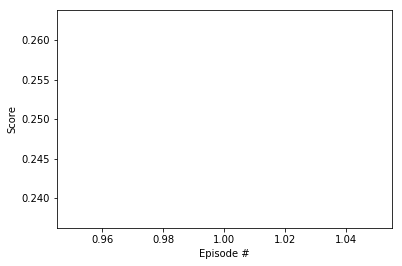

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
TrainedreacherAI = AiAgent(state_size,action_size,random_seed=9)
print(TrainedreacherAI.actor_local)
print(TrainedreacherAI.critic_local)


Actor(
  (fc1): Linear(in_features=33, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=24, bias=True)
  (fc2): Linear(in_features=28, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=1, bias=True)
)


Increased Buffer size so Replay Memory size wud be larger but Minibatch to see the correlations reduced to 100
Discounted Reward made to .997 
Local to Target Network Sync - updated to 0.0017 Learning rate Actor increased to 0.0002 but for critic made it 0.001

theta=0.1, sigma=0.2 - 
Noise sampling since major challenges cud see during training ..arm is just moving clock wise swing mostly. so need more exploration

In [13]:
TrainedreacherAI.load_state_dict(torch.load('checkpoint_actor30.pth'))
TrainedreacherAI.eval()

AttributeError: 'AiAgent' object has no attribute 'load_state_dict'

In [12]:
#Ver 7 19Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 100        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0001         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Window Score: 1.3600
Episode 200	Average Window Score: 2.7800
Episode 300	Average Window Score: 3.6100
Episode 400	Average Window Score: 4.3000
Episode 453	Average Score: 5.2800 

KeyboardInterrupt: 

# History


Episode 100	Average Window Score: 11.3031e: 0.00000
Episode 200	Average Window Score: 7.1321e: 0.000000
Episode 300	Average Window Score: 5.1471e: 0.000000
Episode 400	Average Window Score: 10.1139e: 119.0100
Episode 500	Average Window Score: 13.6738e: 39.53000


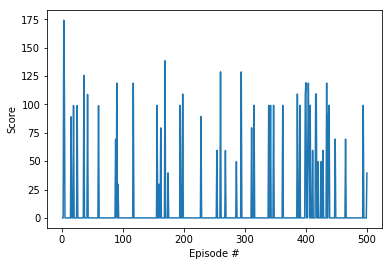

In [18]:
#Ver 5 19Jul
#Change params to default
#BUFFER_SIZE = 300000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.917            # discount factor
#TAU = 0.001              # for soft update of target parameters
#LR_ACTOR = 1e-4         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

seed 9
BUFFER_SIZE = 300000    #int(1e4)  # replay buffer size
BATCH_SIZE = 256        #128        # minibatch size
GAMMA = 0.917            # discount factor
TAU = 0.001              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [ ]:
#V4 17-Jul-20
#Call DDPG
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.0143
Episode 200	Average Score: 0.0796
Episode 300	Average Score: 0.0388
Episode 400	Average Score: 0.0536
Episode 500	Average Score: 0.0720
Episode 600	Average Score: 0.0515
Episode 663	Average Score: 0.0382

seed 575
BUFFER_SIZE = int(1e4)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.97            # discount factor
TAU = 0.001              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [ ]:
#V3 17-Jul-20
#Call DDPG
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.0322
Episode 200	Average Score: 0.0328
Episode 300	Average Score: 0.0322
Episode 400	Average Score: 0.0287
Episode 488	Average Score: 0.0229

In [ ]:
#V2.1 17-Jul-20
#Call DDPG
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.0243
Episode 125	Average Score: 0.0243

BUFFER_SIZE = int(1e4)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [ ]:
#V1.2 17-Jul-20
#Call DDPG
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.0341
Episode 200	Average Score: 0.0613
Episode 300	Average Score: 0.0740
Episode 400	Average Score: 0.0475
Episode 500	Average Score: 0.0214
Episode 580	Average Score: 0.0188

In [ ]:
env.close()

In [ ]:
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30.pth'))

env_info = env.reset(train_mode=False)[brain_name]
scores = np.zeros(num_agents)       
#set initial state
state = env_info.vector_observations

for t in range(1000):
    action = reacherAI.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done   = env_info.local_done
    scores += reward                       
    state = next_state
           
    if np.any(done):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))  

In [11]:

def Ddpg(n_episodes=1000, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        #state = env.reset()
        #reacherAI.reset()
        #score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations  #[0] Current state 
        reacherAI.reset()
        total_Reward = np.zeros(num_agents)
        for t in range(max_t):
            #Select action based on  policy based
            action = reacherAI.act(state)
            action = np.clip(action, -1, 1) 
            #Perform 'action'
            env_info = env.step(action)[brain_name]
            
            #Next State 
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done   = env_info.local_done
            total_Reward += env_info.rewards
            
            state = next_state
            #Replay Memory
            [reacherAI.step(state[i], action[i], reward[i], next_state[i], done[i]) for i in range(num_agents)]
            #reacherAI.step(state, action, reward, next_state, done)
            
            reacherAI.step_learn()
            
            
            if np.any(done):
                break 
        scores_deque.append(np.mean(total_Reward))
        scores.append(np.mean(total_Reward))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores



#Background Work

In [ ]:
#V1.2 hyper params 17-Jul-20 3.40PM  
random_seed = 1
BUFFER_SIZE = int(1e4)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [ ]:
#Call DDPG
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
print (torch.__version__)

In [ ]:
conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

In [ ]:
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30.pth'))

state = env.reset()
for t in range(200):
    action = agent.act(state, add_noise=False)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 


In [ ]:
#

In [ ]:
#Train the Agent - DDPG  Algorithm - simillar from AiNavigator -DQN approach
#Function dqn helps to calculate Agent's optimized score to choose Actor-critic Method
def DDPG(num_episodes=1000, max_t=300, print_every=100):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    

    for i_episode in range(1,num_episodes+1):
        #reset the unity Env_info for each new episode
        env_info = env.reset(train_mode=True)[brain_name]
    
        #set initial state 
        state = env_info.vector_observations[0]
    
        score = 0 
        #Iterative run until all number of episodes done
    
        while True:
            action = ai_agent.act(state,eps)
        
            env_info = env.step(action)[brain_name]        #Take action based on Epsilion Greedy Policy
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished 
            
            ai_agent.step(state, action, reward, next_state, done) # Replay Memory - Learn from potential failure
            
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step            
            if done:                                       # exit loop if episode finished
                break
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=17.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(ai_agent.qnetwork_local.state_dict(), 'checkpointai17.pth')
            break
        
    return scores     

When finished, you can close the environment.

In [10]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 